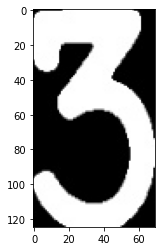

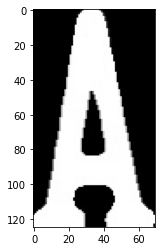

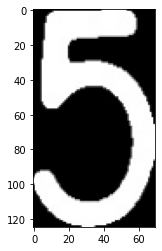

<Figure size 432x288 with 0 Axes>

In [60]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

file_names = ['Ace','Jack', 'Queen', 'King', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine', 'Ten']

def read_images(*file_names):
    
    for i in file_names:
        img = cv2.imread('Card_Imgs/'+i+'.jpg')   # Read the image
        plt.imshow(img)   # Ploting the image using matplotlib
        plt.figure()
        
read_images('Three', 'Ace', 'Five')